In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import re
import seaborn as sns
# import spacy
from tqdm import tqdm
# from krovetzstemmer import Stemmer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pickle
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from gensim.models import KeyedVectors
import warnings
from scipy.sparse import hstack, csr_matrix
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from datetime import datetime
from sklearn.linear_model import LogisticRegression, SGDClassifier
# from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import median
import pickle
from wordcloud import WordCloud
import os
os.chdir(r'D:\Project_2')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
physical_device = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_device[0],True)
len(physical_device)


1

### Reading data

In [4]:
data = pd.read_csv(r'mpst_full_data.csv')

In [5]:
data.head(2)

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb


In [6]:
print("Number of data points in data", data.shape)
print('='*80)
print("The attributes of data :", data.columns.values)

Number of data points in data (14828, 6)
The attributes of data : ['imdb_id' 'title' 'plot_synopsis' 'tags' 'split' 'synopsis_source']


In [7]:
# Checking null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14828 entries, 0 to 14827
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   imdb_id          14828 non-null  object
 1   title            14828 non-null  object
 2   plot_synopsis    14828 non-null  object
 3   tags             14828 non-null  object
 4   split            14828 non-null  object
 5   synopsis_source  14828 non-null  object
dtypes: object(6)
memory usage: 695.2+ KB


No null value is detected, so imputation is not needed.

In [8]:
data['split'].value_counts()

train    9489
test     2966
val      2373
Name: split, dtype: int64

## EDA on 'Categorical features' :

In [9]:
# distributing data on the basis of train, test and validation

train = data.loc[data['split']=='train']
test = data.loc[data['split']=='test']
cv = data.loc[data['split']=='val']

In [10]:
train.shape,test.shape,cv.shape

((9489, 6), (2966, 6), (2373, 6))

### * Data distribution on train, test and validation

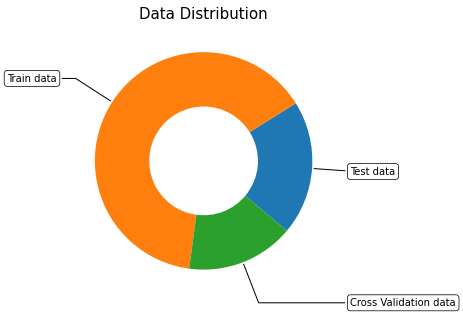

In [11]:
# this code is taken from 
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py

fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))

recipe = ["Test data",
          "Train data",
          "Cross Validation data",
          ]

data_plot = [test.shape[0],train.shape[0],cv.shape[0]]

wedges, texts = ax.pie(data_plot, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

plt.title("Data Distribution",fontsize=15)

plt.show()

Distribution of data are as follows :
* train : 64%
* test : 20%
* cv : 16%

### * Data Source

In [12]:
data['synopsis_source'].value_counts()

wikipedia    10656
imdb          4172
Name: synopsis_source, dtype: int64

Text(0, 0.5, 'Count')

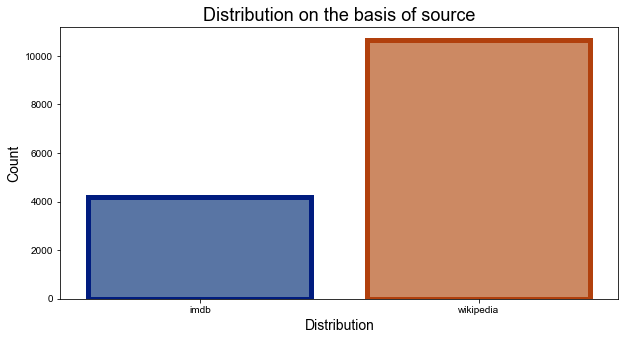

In [13]:
plt.figure(figsize=(10,5))
plt.title('Distribution on the basis of source',fontsize=18)
sns.set_theme(style='darkgrid')
sns.countplot(data['synopsis_source'],linewidth=5,edgecolor=sns.color_palette('dark',3),orient="h")
plt.xlabel('Distribution',fontsize=14)
plt.ylabel('Count',fontsize=14)

Distribution on the basis source :
* imdb : 28%
* wikipedia : 72%

In [14]:
def preprocess_tags(s):
    """Retuens separate words from tags.
    """
    s = re.sub(r"\s+",'_',s)
    s = re.sub(r"\,_+", ' ', s)
    return s

In [15]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(' '), binary='true')
y = vectorizer.fit_transform(data['tags'].apply(preprocess_tags))

In [16]:
print('No of Unique tags: ', y.shape[1])

No of Unique tags:  71


In [17]:
# data_train['tags'].head()

## EDA on 'Text' features :

### Word frequency in 'Title' :

In [18]:
a = ['I, am, a, boy, good vs evil', 'She, is, good girl']
a = ', '.join([i for i in a])
a = a.split(', ')
a

# for i in a:
#     print(i)
# b = ''.join([text for text in a]) 
# d = [z.strip() for z in a.split(',')]
# d 

['I', 'am', 'a', 'boy', 'good vs evil', 'She', 'is', 'good girl']

In [19]:
def freq_words(x, terms = 30): 
  """
  Returns a dataframe of words and word's count.
  """
  all_words = ', '.join([text for text in x]) 
  all_words = all_words.split(', ') 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 50 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  return d,words_df,fdist

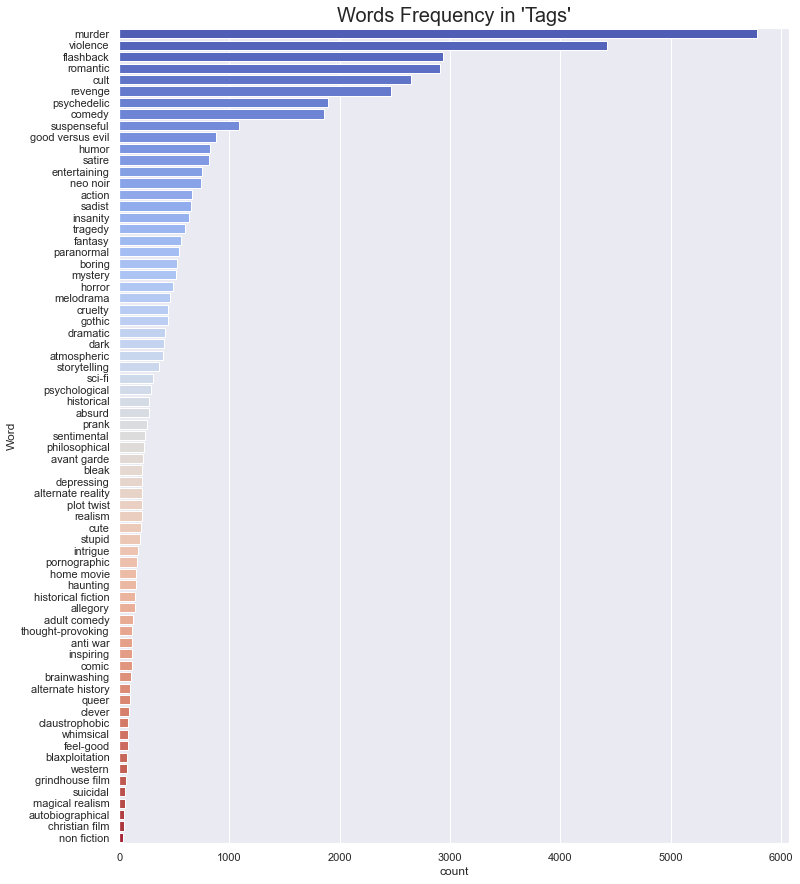

In [20]:
d,words_df,fdist = freq_words(data['tags'], 300)

# visualize words and frequencies
plt.figure(figsize=(12,15))
plt.title('Words Frequency in \'Tags\'',fontsize=20) 
ax = sns.barplot(data=d, x= "count", y = "word",palette='coolwarm') 
ax.set(ylabel = 'Word') 
plt.show()

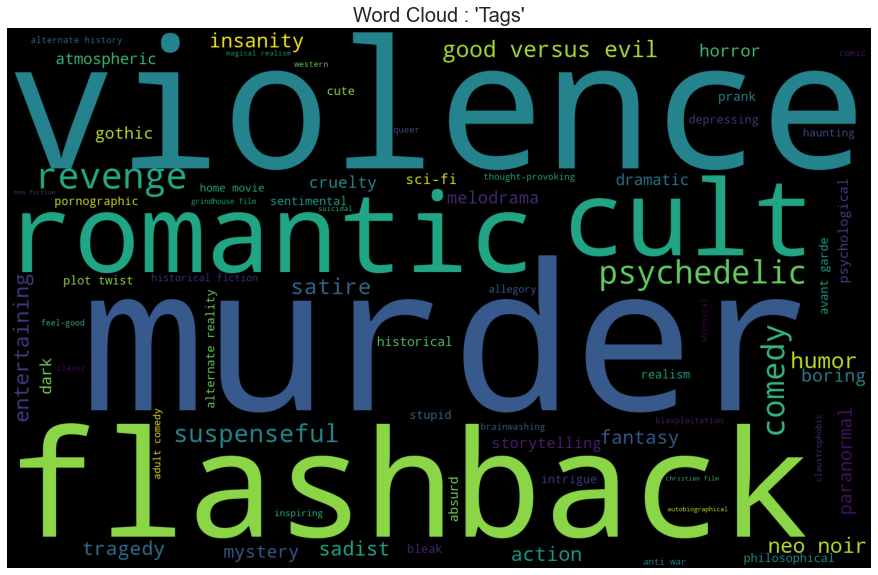

In [21]:
wordcloud = WordCloud(background_color='black',
            width=1600,
            height=1000,
      ).generate_from_frequencies(dict(zip(fdist.keys(),fdist.values())))

fig = plt.figure(figsize=(12,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud : \'Tags\'',fontsize=20)
plt.show()

Some of most frequent tags are :
* Murder,voilence,flashback,romantic,cult,revenge

In [22]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 50 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  return d,words_df,fdist

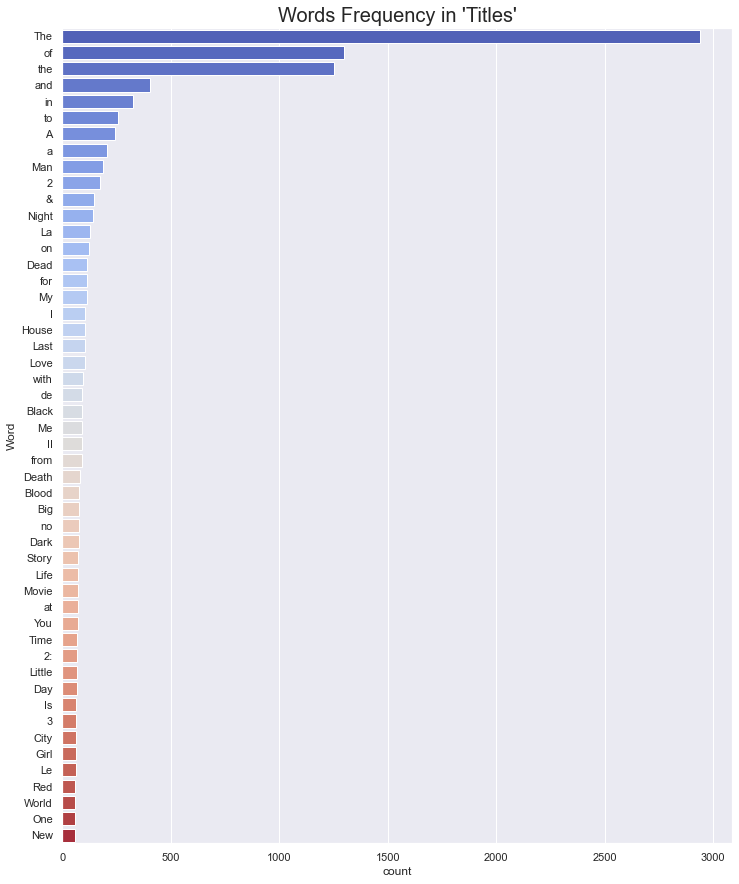

In [23]:
d,words_df,fdist = freq_words(data['title'], 50)

# visualize words and frequencies
plt.figure(figsize=(12,15))
plt.title('Words Frequency in \'Titles\'',fontsize=20) 
ax = sns.barplot(data=d, x= "count", y = "word",palette='coolwarm') 
ax.set(ylabel = 'Word') 
plt.show()

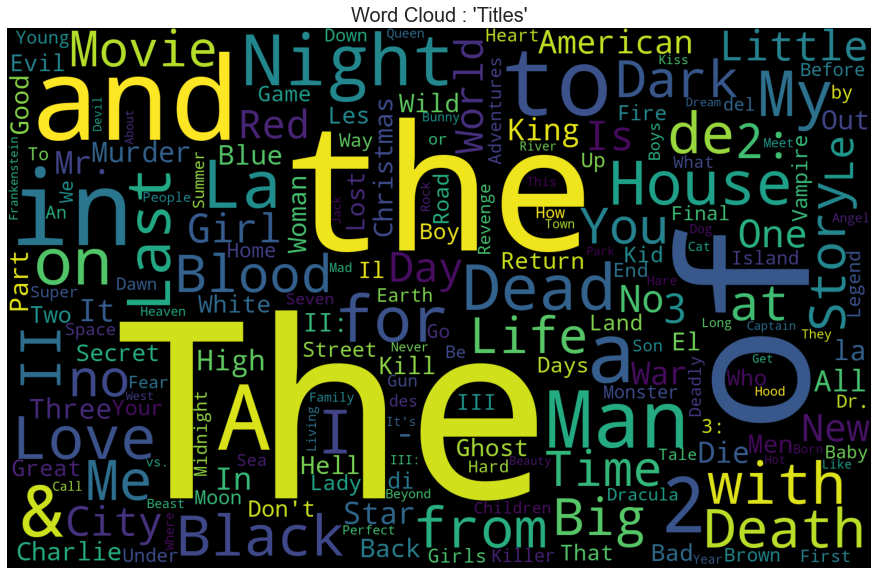

In [24]:
# Refrence : https://www.geeksforgeeks.org/generating-word-cloud-python/

wordcloud = WordCloud(background_color='black',
            width=1600,
            height=1000,
      ).generate_from_frequencies(dict(zip(fdist.keys(),fdist.values())))

fig = plt.figure(figsize=(12,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud : \'Titles\'',fontsize=20)
plt.show()

Here we can clearly observe most of the words used in tags like 'The', 'of', 'and', 'in', 'to' etc are from stopwords.
The word 'The' is used for execptionally large amount of times.

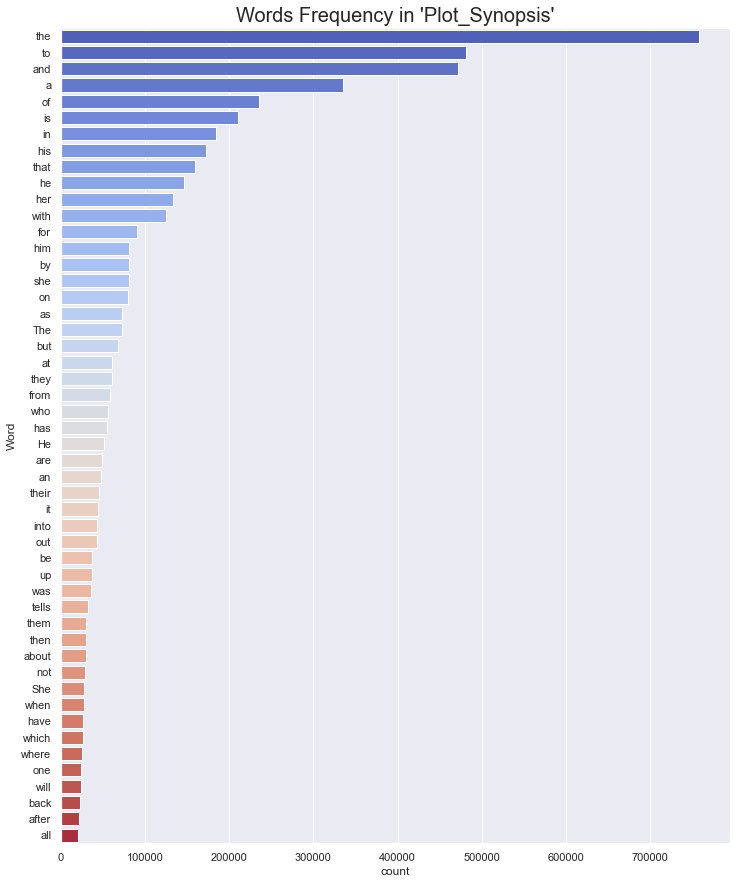

In [25]:
d,words_df,fdist = freq_words(data['plot_synopsis'], 50)

# visualize words and frequencies
plt.figure(figsize=(12,15))
plt.title('Words Frequency in \'Plot_Synopsis\'',fontsize=20) 
ax = sns.barplot(data=d, x= "count", y = "word",palette='coolwarm') 
ax.set(ylabel = 'Word') 
plt.show()

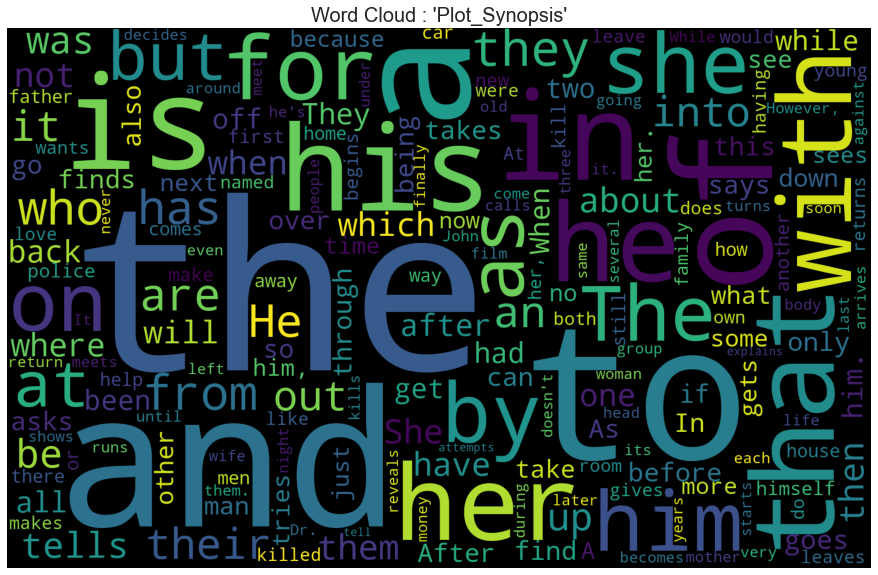

In [26]:
wordcloud = WordCloud(background_color='black',
            width=1600,
            height=1000,
      ).generate_from_frequencies(dict(zip(fdist.keys(),fdist.values())))

fig = plt.figure(figsize=(12,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud : \'Plot_Synopsis\'',fontsize=20)
plt.show()

Here we can clearly observe most of the words used in plot_synopsis are : 'The', 'of', 'and', 'in', 'to' etc

In [27]:
len(d['word'].unique())

50

In [28]:
d['word'].values

array(['the', 'to', 'and', 'a', 'of', 'is', 'in', 'his', 'that', 'he',
       'her', 'with', 'for', 'him', 'by', 'she', 'on', 'as', 'The', 'but',
       'at', 'they', 'from', 'who', 'has', 'He', 'are', 'an', 'their',
       'it', 'into', 'out', 'be', 'up', 'was', 'tells', 'them', 'then',
       'about', 'not', 'She', 'when', 'have', 'which', 'where', 'one',
       'will', 'back', 'after', 'all'], dtype=object)

In [29]:
data.tags

0                cult, horror, gothic, murder, atmospheric
1                                                 violence
2                                                 romantic
3                   inspiring, romantic, stupid, feel-good
4        cruelty, murder, dramatic, cult, violence, atm...
                               ...                        
14823                                       comedy, murder
14824                           good versus evil, violence
14825                                             anti war
14826                                               murder
14827                                       christian film
Name: tags, Length: 14828, dtype: object

Text(0.5, 1.0, 'Distribution Plot')

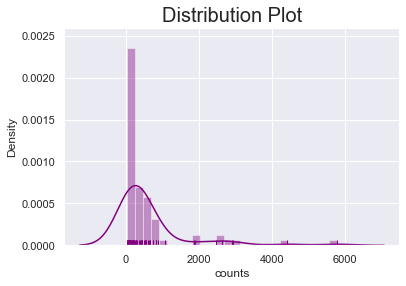

In [30]:
tags = vectorizer.get_feature_names()
total = y.shape[0]
counts = y.toarray().sum(axis = 0)
d = pd.DataFrame({'counts':counts,'tags':tags})
e = d.sort_values(by=['counts'],ascending=False)
sns.distplot(d['counts'],rug=True,color='purple')
plt.title('Distribution Plot',fontsize=20)

* Above plot represents distribution of various words VS word density.
* Highest density is noticed where word counts are less (from 0 to 100).
* Distribution is slightly skewed towards right.

Text(0.5, 1.0, 'Box plot of tag frequency')

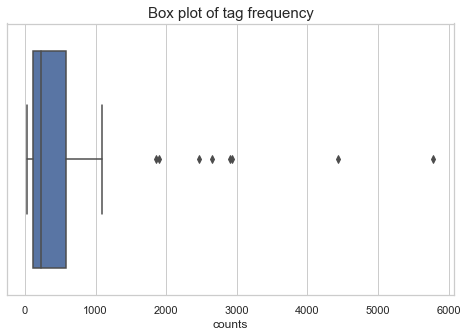

In [31]:
num = e.counts

plt.figure(figsize=(8,5))
sns.set_theme(style='whitegrid')
sns.boxplot(num,showfliers=True)
plt.title('Box plot of tag frequency',fontsize=15)

Text(0, 0.5, 'tag frequency')

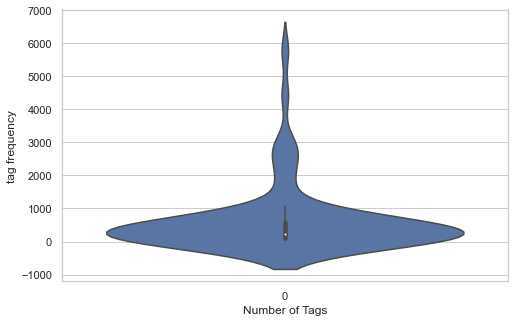

In [32]:
# Obsetving the quantiles using the violin plot and box .

plt.figure(figsize=(8,5))

plt.subplot()
sns.violinplot(data = num,color='b')
plt.xlabel("Number of Tags")
plt.ylabel("tag frequency")

Here we can observe that points are distributed in region upto frequency = 2000

Text(0, 0.5, 'Tag frequency')

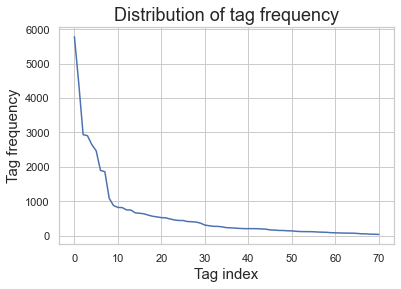

In [33]:

sns.set_theme(style='whitegrid')
plt.title('Distribution of tag frequency',fontsize=18)
plt.plot(num.values)
plt.xlabel('Tag index',fontsize=15)
plt.ylabel('Tag frequency',fontsize=15)

* The distribution of tag frequency seems to follow 'Pareto Distribution'.
* Around 80% of outcomes result from 20% of all causes.
* Heighest and lowest frequent words may not be that useful in tag prediction.
* Preprocessing is needed for most useful words.

## Preprocessing

### Duplicates

In [34]:
# Checking for duplicates in title
print('Duplicates in title :',data.duplicated(['title']).sum())
data[data.duplicated(['title'])].head(2)

Duplicates in title : 1071


,imdb_id,title,plot_synopsis,tags,split,synopsis_source
643,tt0082031,Arthur,Arthur Bach is a rich socialite from a financi...,"comedy, entertaining",test,imdb
776,tt0837565,The Witches of Eastwick,This unsold TV series pilot opens with three y...,paranormal,train,imdb


In [35]:
# checking few duplicate entries manually
idx = data[data['title']=='Arthur'].index
print('*'*200,'\n')
print(data.loc[idx[0]].plot_synopsis,'\n')
print('*'*200,'\n')
print(data.loc[idx[1]].plot_synopsis,'\n')
print('*'*200,'\n')

******************************************************************************************************************************************************************************************************** 

Arthur (Russell Brand) is a drunken playboy who revels in party and drinking. On the way to a dress party, he and Bitterman (Luis Guzman) dress as Batman and Robin, get arrested, then bail out everyone from jail.The next day, Hobson (Helen Mirren) cleans up after Arthur and kicks out various hookers. Hobson nannies Arthur, trying to keep him sober. She takes him to see his mother Vivienne (Geraldine James), who tells him he must marry Susan Johnson (Jennifer Garner) to stabilize the family business. Arthur proceeds to spend money as fast as possible, then bumps into Naomi (Greta Gerwig). They share a moment, and Arthur asks to see her again, but he still has to marry Susan.He goes to ask Susan's father Burt (Nick Nolte) for her hand in marriage. Burt approves, only because he thinks Sus

Plot synopsis with same title (same movie) are distinct and may be useful for recruiting tags, so we will keep all the entries.

In [36]:
# Checking for duplicates in title and plot_synopsis
print('Duplicates in title and plot_synopsis :',data.duplicated(['plot_synopsis']).sum())
text = data[data.duplicated(['title', 'plot_synopsis'])]['plot_synopsis'][1198]
data[data['plot_synopsis'] == text]

Duplicates in title and plot_synopsis : 980


,imdb_id,title,plot_synopsis,tags,split,synopsis_source
182,tt0082186,Clash of the Titans,"In ancient times, after defeating their predec...","cult, revenge, psychedelic",train,wikipedia
1198,tt0800320,Clash of the Titans,"In ancient times, after defeating their predec...","fantasy, violence, flashback, good versus evil...",train,wikipedia
10042,tt1589998,Clash of the Titans,"In ancient times, after defeating their predec...","good versus evil, violence",val,wikipedia


In [37]:
# Droping duplicates
clean_data = data.drop_duplicates(subset='plot_synopsis',keep='first',inplace=False)
clean_data.shape

(13848, 6)

In [38]:
clean_data['split'].value_counts()

train    8860
test     2794
val      2194
Name: split, dtype: int64

In [39]:
clean_data.shape

(13848, 6)

In [40]:
# Merging validation data with train data

clean_data['split'] = clean_data['split'].replace('val', 'train')

In [41]:
gb = clean_data.groupby('split')
gdata = [gb.get_group(x) for x in gb.groups]
data_test = pd.DataFrame(gdata[0]).drop(['split'], axis = 1)
data_train = pd.DataFrame(gdata[1]).drop(['split'], axis = 1)

In [42]:
print('Shape of Train data: ', data_train.shape)
print('Shape of Test data: ', data_test.shape)

Shape of Train data:  (11054, 5)
Shape of Test data:  (2794, 5)


### Preprocessing the plot_synopses
* Removing titles like Dr., Mr., Mrs., Miss, Master, etc.
* Removing stopwords.
* Removing Special Characters.
* Stem all the words.
* Encoding all persons names as 'person'.

In [43]:
name_titles = ['dr', 'mr', 'mrs', 'miss', 'master', 'mister', 'mistress']

re_names = re.compile(r"\b(" + "|".join(name_titles) + ")\\W", re.I)

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
        "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
        'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
        'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
        'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
        'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
        'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
        'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
        'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
        'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
        's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
        've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
        "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
        'won', "won't", 'wouldn', "wouldn't"]

In [44]:
from nltk.stem import SnowballStemmer 

In [45]:
import spacy
nlp = spacy.load("en_core_web_sm")


from sentic import SenticPhrase
mood_tags = ['#interest','#admiration','#sadness','#disgust','#joy','#anger','#fear','#surprise']

stemmer = SnowballStemmer('english')
def stem(sentence):
    tokens = sentence.split(' ')
    stemmed = ''
    for word in tokens:
        stemmed += stemmer.stem(word) + ' '
    return stemmed

def preprocess_synopses(plot_synopses):
    preprocessed_synopses = []
    sentiments = []
    sentic_vector = []

    for line in tqdm(plot_synopses):
        
        line= re.sub(r'\([^()]*\)', '', line)
        line= re.sub(r"won't", "will not", line)
        line= re.sub(r"can\'t", "can not", line)
        line= re.sub(r"n\'t", " not", line)
        line= re.sub(r"\'re", " are", line)
        line= re.sub(r"\'s", " is", line)
        line= re.sub(r"\'d", " would", line)
        line= re.sub(r"\'ll", " will", line)
        line= re.sub(r"\'t", " not", line)
        line= re.sub(r"\'ve", " have", line)
        line= re.sub(r"\'m", " am", line)
        line= line.replace('"','')
        line= line.replace('\\r', ' ')
        line= line.replace('\\"', ' ')
        line= line.replace('\\n', ' ')
        line= re.sub('[^A-Za-z.,]+', ' ', line)
        line= re_names.sub("", line)
        line= line.replace('.',' . ')
        line= ' '.join(word for word in line.split() if word not in stopwords)
        
        line_nlp  = nlp(line)
        entities = [str(e).strip() for e in line_nlp.ents if e.label_=='PERSON']
        persons = list(set(entities))

        # Replacing character names with 'person'
        line_new = line
        for person in persons:
            line_new = line_new.replace(person, 'person')
            
        line_new = re.sub('[^A-Za-z0-9]+', ' ', line_new)
        line_new = line_new.lower().strip()
        line_new = ' '.join(word for word in line_new.split() if word not in stopwords)
        

        #appending sentiments [neg, neu, pos]
        sentis = []
        sid = SentimentIntensityAnalyzer()
        ss = sid.polarity_scores(line_new)

        for k in ss:
            sentis.append(ss[k])
        sentiments.append(sentis[:-1])
        
        #Sentic Features
        sentic_feats = []
        sp = SenticPhrase(line_new)
        sentic_feats.extend(list(sp.get_sentics().values()))
        get_mood_tags = sp.get_moodtags()
        sentic_feats.extend([get_mood_tags.get(i,0) for i in mood_tags])
        sentic_feats.append(sp.get_polarity())
        sentic_vector.append(sentic_feats)
        
        #stemming
        line_new = stem(line_new)
        
        #appending the preprocessed string to list
        preprocessed_synopses.append(line_new)

    return preprocessed_synopses, sentiments, sentic_vector

In [46]:
# preprocessed_synopses_train, sentiments, sentic_vector = preprocess_synopses(data_train['plot_synopsis'])

In [47]:
import pickle
# pickle.dump(preprocessed_synopses_train,open('preprocessed_synopses_train.pickle','wb'))
# pickle.dump(sentiments,open('sentiments.pickle','wb'))
# pickle.dump(sentic_vector,open('sentic_vector.pickle','wb'))

In [48]:
# import gc
# del preprocessed_synopses_train
# del sentiments
# del sentic_vector
# gc.collect()

In [49]:
preprocessed_synopses_train = pickle.load(open('preprocessed_synopses_train.pickle','rb'))
sentiments = pickle.load(open('sentiments.pickle','rb'))
sentic_vector = pickle.load(open('sentic_vector.pickle','rb'))

In [50]:
data_train['plot_synopsis'] = preprocessed_synopses_train
senti_train_df = pd.DataFrame(data = np.array(sentiments), index = data_train.index, columns = ['senti_neg', 'senti_neu', 'senti_pos'])
sentic_train_df = pd.DataFrame(data = sentic_vector, index = data_train.index)
data_train = pd.concat([data_train, senti_train_df, sentic_train_df], axis = 1)
data_train.head(1)

,imdb_id,title,plot_synopsis,tags,synopsis_source,senti_neg,senti_neu,senti_pos,0,1,...,3,4,5,6,7,8,9,10,11,12
0,tt0057603,I tre volti della paura,note synopsi orgin italian releas segment cert...,"cult, horror, gothic, murder, atmospheric",imdb,0.249,0.642,0.109,0.01968,0.02137,...,0.0147,32,55,13,36,22,17,10,15,0.00272


In [51]:
data_train.to_csv('data_train.csv')

In [52]:
data_train.head(1)

,imdb_id,title,plot_synopsis,tags,synopsis_source,senti_neg,senti_neu,senti_pos,0,1,...,3,4,5,6,7,8,9,10,11,12
0,tt0057603,I tre volti della paura,note synopsi orgin italian releas segment cert...,"cult, horror, gothic, murder, atmospheric",imdb,0.249,0.642,0.109,0.01968,0.02137,...,0.0147,32,55,13,36,22,17,10,15,0.00272


In [53]:
# preprocessed_synopses_test, sentiments_test, sentic_vector_test = preprocess_synopses(data_test['plot_synopsis'])

# data_test['plot_synopsis'] = preprocessed_synopses_test
# senti_test_df = pd.DataFrame(data = np.array(sentiments_test), index = data_test.index, columns = ['senti_neg', 'senti_neu', 'senti_pos'])
# sentic_test_df = pd.DataFrame(sentic_vector_test, index = data_test.index)
# data_test = pd.concat([data_test, senti_test_df, sentic_test_df], axis = 1)
# data_test.to_csv('data_test.csv')

In [54]:
data_test = pd.read_csv('data_test.csv', index_col = 0)
data_test.head(2)

,imdb_id,title,plot_synopsis,tags,synopsis_source,senti_neg,senti_neu,senti_pos,0,1,...,3,4,5,6,7,8,9,10,11,12
2,tt0033045,The Shop Around the Corner,person gift store budapest workplac person kra...,romantic,imdb,0.15,0.688,0.162,-0.127631,0.045985,...,-0.044400,27,30,19,20,7,15,6,6,-0.083523
15,tt1937113,Call of Duty: Modern Warfare 3,hour end previous game death traitor general s...,good versus evil,imdb,0.22,0.686,0.094,0.009249,0.039893,...,-0.117452,75,87,34,77,45,26,29,21,-0.059325


In [55]:
def max_len(a):
    """Calculates length of the string. """
    x=a.split()
    return len(x)

In [56]:
data_train.shape

(11054, 21)

In [57]:
max_len_plot_syn_tr = max(data_train['plot_synopsis'].apply(max_len))

### Vectorizing labels

In [58]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(", "), binary='true')
y_train = vectorizer.fit_transform(data_train['tags']).toarray()
y_test=vectorizer.transform(data_test['tags']).toarray()

In [59]:
set(data_train['tags'][0].split(','))

{' atmospheric', ' gothic', ' horror', ' murder', 'cult'}

In [60]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [61]:
y_train.shape,y_test.shape

((11054, 71), (2794, 71))

In [62]:
# vectorizing plot_synopsis

from keras.preprocessing.text import Tokenizer
vect=Tokenizer()
vect.fit_on_texts(data_train['plot_synopsis'])
vocab_size = len(vect.word_index) + 1
print(vocab_size)

55085


In [63]:
# encoding plot_synopsis (train)

encoded_docs_train = vect.texts_to_sequences(data_train['plot_synopsis'])
max_length = vocab_size
padded_docs_train = tf.keras.utils.pad_sequences(encoded_docs_train, maxlen=1400, padding='post')
print(padded_docs_train)

[[  387  3171 23080 ...     0     0     0]
 [   17  1803    57 ...     0     0     0]
 [    1  6510     2 ...     0     0     0]
 ...
 [  115   718     1 ...     0     0     0]
 [ 3312  1971   334 ...     0     0     0]
 [ 1242  1924  1736 ...     0     0     0]]


In [64]:
padded_docs_train.shape

(11054, 1400)

In [65]:
# encoding plot_synopsis (test)

encoded_docs_test = vect.texts_to_sequences(data_test['plot_synopsis'])
max_length = vocab_size
padded_docs_test = tf.keras.utils.pad_sequences(encoded_docs_test, maxlen=1400, padding='post')
print(padded_docs_test)

[[    1  1013   415 ...     0     0     0]
 [  572    53   507 ...     0     0     0]
 [ 4142  5187   130 ...     0     0     0]
 ...
 [    1 16504 52361 ...     0     0     0]
 [    1   299  4892 ...     0     0     0]
 [ 1412  1533    18 ...     0     0     0]]


In [66]:
padded_docs_test.shape

(2794, 1400)

In [67]:
def f1micro(y_true, y_pred):
    return tf.py_func(f1_score(y_true, y_pred,average='mirco'),tf.double)


# Modeling

### Using LSTM

In [68]:
from keras.layers import Dense, Flatten, LSTM, Conv1D, Conv2D, MaxPooling1D, Dropout, Activation,GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
# import keras.optimizers.Adam
from time import time
from keras.callbacks import TensorBoard
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
# from keras.optimizers import Adam

# from keras.layers.embeddings import Embedding
from keras.callbacks import ReduceLROnPlateau

In [69]:
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_f1micro', verbose=0, save_best_only=True, mode='max')

In [70]:
checkpoint = ModelCheckpoint(filepath, monitor='val_f1micro', verbose=0, save_best_only=True, mode='max')
model = Sequential()
# model.add(Embedding(max_words, 20, input_length=maxlen))
model.add(Embedding(vocab_size, output_dim=50, input_length=1400))
model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.15))
model.add(LSTM(64))
model.add(Dropout(0.5))
# model.add(GlobalMaxPool1D())
model.add(Dense(71, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1400, 50)          2754250   
                                                                 
 lstm (LSTM)                 (None, 1400, 128)         91648     
                                                                 
 dropout (Dropout)           (None, 1400, 128)         0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 71)                4615      
                                                                 
Total params: 2,899,921
Trainable params: 2,899,921
Non-

In [71]:
!rm -rf ./log1

In [72]:
file_path = "model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=2, min_lr=0.0001)
# lr_schedule = LearningRateScheduler(learning_rate_scheduler, verbose=0)
checkpoint = ModelCheckpoint(filepath = file_path, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')
# earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.35, patience=2, verbose=1)
# terminate = TerminateNaN()   
# metrics = Perf_Metric()
logdir = 'log1'
tensorboard = TensorBoard(log_dir=logdir)

In [73]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=4),
    ModelCheckpoint(filepath='model-simple1.hdf5', save_best_only=True),
    tensorboard
]

history = model.fit(padded_docs_train, y_train,
                    # class_weight='balanced',
                    epochs=5,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=callbacks)


Epoch 1/5
311/311 [==============================] - 56s 148ms/step - loss: 0.1955 - accuracy: 0.0847 - val_loss: 0.1088 - val_accuracy: 0.1691 - lr: 0.0010
Epoch 2/5
311/311 [==============================] - 45s 144ms/step - loss: 0.1536 - accuracy: 0.1126 - val_loss: 0.1097 - val_accuracy: 0.1691 - lr: 0.0010
Epoch 3/5
311/311 [==============================] - 49s 158ms/step - loss: 0.1507 - accuracy: 0.1265 - val_loss: 0.1112 - val_accuracy: 0.1682 - lr: 0.0010
Epoch 4/5
311/311 [==============================] - 49s 159ms/step - loss: 0.1500 - accuracy: 0.1348 - val_loss: 0.1097 - val_accuracy: 0.1691 - lr: 0.0010
Epoch 5/5
311/311 [==============================] - 49s 157ms/step - loss: 0.1492 - accuracy: 0.1379 - val_loss: 0.1100 - val_accuracy: 0.1691 - lr: 0.0010


In [74]:
%load_ext tensorboard

In [75]:
%tensorboard --logdir 'log1'

Reusing TensorBoard on port 6006 (pid 4296), started 15:14:20 ago. (Use '!kill 4296' to kill it.)

In [76]:
# !rm -rf ./logs

In [77]:
predictions=model.predict([padded_docs_test])
thresholds=[0.1,0.15,0.17,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

88/88 [==============================] - 6s 63ms/step


In [78]:
from sklearn.metrics import f1_score,precision_score,recall_score
for val in thresholds:
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
   
    print("Micro-average quality numbers for threshold = {}".format(val))
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers for threshold = 0.1
Precision: 0.2165, Recall: 0.5603, F1-measure: 0.3123
Micro-average quality numbers for threshold = 0.15
Precision: 0.2440, Recall: 0.4777, F1-measure: 0.3230
Micro-average quality numbers for threshold = 0.17
Precision: 0.2444, Recall: 0.4752, F1-measure: 0.3227
Micro-average quality numbers for threshold = 0.2
Precision: 0.2993, Recall: 0.3014, F1-measure: 0.3004
Micro-average quality numbers for threshold = 0.3
Precision: 0.3484, Recall: 0.2251, F1-measure: 0.2735
Micro-average quality numbers for threshold = 0.4
Precision: 0.5065, Recall: 0.0045, F1-measure: 0.0089
Micro-average quality numbers for threshold = 0.5
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000
Micro-average quality numbers for threshold = 0.6
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000
Micro-average quality numbers for threshold = 0.7
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000
Micro-average quality numbers for threshold = 0.8
Precision: 0

## Observation

In above model we have used layers as follows :
* Embedding_layer >> LSTM >> Drop_out >> LSTM >> Drop_out >> LSTM
* Validation accuracy = 16.19 %

Trend of F1_score with respect to threshold values :
* F1_score is observed to decrease with rise in threshold values.
* Best F1_score = 32.28% 

### Using CNN

In [79]:
filter_length = 300

checkpoint = ModelCheckpoint(filepath, monitor='val_f1micro', verbose=0, save_best_only=True, mode='max')
model = Sequential()
model.add(Embedding(vocab_size, output_dim=50, input_length=1400))
model.add(Dropout(0.15))
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(71, activation='sigmoid'))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1400, 50)          2754250   
                                                                 
 dropout_2 (Dropout)         (None, 1400, 50)          0         
                                                                 
 conv1d (Conv1D)             (None, 1398, 300)         45300     
                                                                 
 global_max_pooling1d (Globa  (None, 300)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 71)                21371     
                                                                 
 activation (Activation)     (None, 71)                0         
                                                      

In [80]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [81]:
os.chdir(r'D:\Project_2\log')
file_path = "model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=2, min_lr=0.0001)
checkpoint = ModelCheckpoint(filepath = file_path, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')
logdir = 'log2'
tensorboard = TensorBoard(log_dir=logdir)

In [82]:
callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=4),
    ModelCheckpoint(filepath='model-2.h5', save_best_only=True),
    tensorboard
]

In [83]:

history = model.fit(padded_docs_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=callbacks)


Epoch 1/5
311/311 [==============================] - 13s 30ms/step - loss: 0.7132 - accuracy: 0.0779 - val_loss: 0.6932 - val_accuracy: 0.1555 - lr: 0.0010
Epoch 2/5
311/311 [==============================] - 9s 28ms/step - loss: 0.6932 - accuracy: 0.1305 - val_loss: 0.6932 - val_accuracy: 0.1664 - lr: 0.0010
Epoch 3/5
311/311 [==============================] - 9s 28ms/step - loss: 0.6932 - accuracy: 0.1342 - val_loss: 0.6932 - val_accuracy: 0.1673 - lr: 0.0010
Epoch 4/5
311/311 [==============================] - 9s 30ms/step - loss: 0.6932 - accuracy: 0.1352 - val_loss: 0.6932 - val_accuracy: 0.1673 - lr: 0.0010
Epoch 5/5
311/311 [==============================] - 9s 29ms/step - loss: 0.6931 - accuracy: 0.1352 - val_loss: 0.6932 - val_accuracy: 0.1673 - lr: 0.0010


In [84]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [85]:
%tensorboard --logdir 'log2'

Reusing TensorBoard on port 6006 (pid 14000), started 13:54:58 ago. (Use '!kill 14000' to kill it.)

In [86]:
'!kill 14000'

'!kill 14000'

In [87]:
!rm -rf ./logs

In [88]:
predictions=model.predict([padded_docs_test])
for val in thresholds:
    print("For threshold: ", val)
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
   
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

88/88 [==============================] - 1s 7ms/step
For threshold:  0.1
Micro-average quality numbers
Precision: 0.0436, Recall: 1.0000, F1-measure: 0.0836
For threshold:  0.15
Micro-average quality numbers
Precision: 0.0436, Recall: 1.0000, F1-measure: 0.0836
For threshold:  0.17
Micro-average quality numbers
Precision: 0.0436, Recall: 1.0000, F1-measure: 0.0836
For threshold:  0.2
Micro-average quality numbers
Precision: 0.0436, Recall: 1.0000, F1-measure: 0.0836
For threshold:  0.3
Micro-average quality numbers
Precision: 0.0436, Recall: 1.0000, F1-measure: 0.0836
For threshold:  0.4
Micro-average quality numbers
Precision: 0.0436, Recall: 1.0000, F1-measure: 0.0836
For threshold:  0.5
Micro-average quality numbers
Precision: 0.0436, Recall: 1.0000, F1-measure: 0.0836
For threshold:  0.6
Micro-average quality numbers
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000
For threshold:  0.7
Micro-average quality numbers
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000
For thres

## Observation

In above model we have used layers as follows :
* Embedding_layer >> Drop_out >> Conv1D >> GlobalMaxPool >> Dense_layer
* Validation accuracy = 6.69 %

Trend of F1_score with respect to threshold values :
* F1_score is observed to be constant (= 0.0836) for initial threshold values.
* Best F1_score = 8.36% 

### CNN + LSTM

In [89]:
filter_length = 300
checkpoint = ModelCheckpoint(filepath, monitor='val_f1micro', verbose=0, save_best_only=True, mode='max')
model = Sequential()
model.add(Embedding(vocab_size, 2, input_length=1400))
model.add(Dropout(0.5))
model.add(LSTM(128,return_sequences=True))
model.add(Conv1D(300, 3, activation='relu'))
model.add(GlobalMaxPool1D())
# model.add(Conv1D(200, 3, activation='relu'))
# model.add(GlobalMaxPool1D())
model.add(Dense(71))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1400, 2)           110170    
                                                                 
 dropout_3 (Dropout)         (None, 1400, 2)           0         
                                                                 
 lstm_2 (LSTM)               (None, 1400, 128)         67072     
                                                                 
 conv1d_1 (Conv1D)           (None, 1398, 300)         115500    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 300)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 71)                21371     
                                                      

In [90]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [91]:
file_path = "model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=2, min_lr=0.0001)
# lr_schedule = LearningRateScheduler(learning_rate_scheduler, verbose=0)
checkpoint = ModelCheckpoint(filepath = file_path, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')
# earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.35, patience=2, verbose=1)
# terminate = TerminateNaN()   
# metrics = Perf_Metric()
logdir = 'log3'
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [92]:
callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=4),
    ModelCheckpoint(filepath='model-2.h5', save_best_only=True),
    tensorboard_callback
]

In [93]:
model.fit(padded_docs_train, y_train,
        #   class_weight='balanced',
          epochs=5,
          batch_size=32,
          validation_split=0.2)
predictions=model.predict(padded_docs_test)

Epoch 1/5
277/277 [==============================] - 38s 127ms/step - loss: 0.1719 - accuracy: 0.1209 - val_loss: 0.1124 - val_accuracy: 0.1651
Epoch 2/5
277/277 [==============================] - 34s 122ms/step - loss: 0.1499 - accuracy: 0.1304 - val_loss: 0.1122 - val_accuracy: 0.1651
Epoch 3/5
277/277 [==============================] - 34s 122ms/step - loss: 0.1495 - accuracy: 0.1316 - val_loss: 0.1144 - val_accuracy: 0.1651
Epoch 4/5
277/277 [==============================] - 34s 123ms/step - loss: 0.1483 - accuracy: 0.1357 - val_loss: 0.1177 - val_accuracy: 0.1651
Epoch 5/5
88/88 [==============================] - 4s 41ms/step


In [94]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [95]:
%tensorboard --logdir 'log3'

In [96]:
!rm -rf ./logs

In [97]:
predictions=model.predict([padded_docs_test])
for val in thresholds:
    print("For threshold: ", val)
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
   
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

88/88 [==============================] - 4s 36ms/step
For threshold:  0.1
Micro-average quality numbers
Precision: 0.1975, Recall: 0.5949, F1-measure: 0.2966
For threshold:  0.15
Micro-average quality numbers
Precision: 0.2286, Recall: 0.5131, F1-measure: 0.3163
For threshold:  0.17
Micro-average quality numbers
Precision: 0.2390, Recall: 0.4776, F1-measure: 0.3186
For threshold:  0.2
Micro-average quality numbers
Precision: 0.2637, Recall: 0.4044, F1-measure: 0.3192
For threshold:  0.3
Micro-average quality numbers
Precision: 0.3586, Recall: 0.2131, F1-measure: 0.2673
For threshold:  0.4
Micro-average quality numbers
Precision: 0.4335, Recall: 0.0954, F1-measure: 0.1564
For threshold:  0.5
Micro-average quality numbers
Precision: 0.5283, Recall: 0.0065, F1-measure: 0.0128
For threshold:  0.6
Micro-average quality numbers
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000
For threshold:  0.7
Micro-average quality numbers
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000
For thre

## Observation

In above model we have used layers as follows :
* Embedding_layer >> Drop_out >> LSTM >> Conv1D >> GlobalMaxPool >> Dense_layer
* Validation accuracy = 16.51 %

Trend of F1_score with respect to threshold values :
* F1_score is observed to be rise initially with increasing thresholds and then fall for higher thresholds.
* Best F1_score = 35.90% 

## BERT for multi-label classification 

In [98]:
data_train.head(2)

,imdb_id,title,plot_synopsis,tags,synopsis_source,senti_neg,senti_neu,senti_pos,0,1,...,3,4,5,6,7,8,9,10,11,12
0,tt0057603,I tre volti della paura,note synopsi orgin italian releas segment cert...,"cult, horror, gothic, murder, atmospheric",imdb,0.249,0.642,0.109,0.019680,0.021370,...,0.014700,32,55,13,36,22,17,10,15,0.002720
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,two thousand year ago nhagruul foul sorcer rev...,violence,imdb,0.325,0.591,0.084,0.043867,0.305778,...,-0.042644,23,16,8,15,15,10,3,0,0.047156


In [99]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [100]:
X_train = data_train['plot_synopsis']
y_train = y_train
X_test = data_test['plot_synopsis']
y_test = y_test

In [101]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((11054,), (2794,), (11054, 71), (2794, 71))

In [102]:
import tensorflow_hub as hub
from tensorflow.keras.models import Model

In [103]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55.
max_seq_length = 55

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#ref https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [104]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 55)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 55)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 55)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 55, 768)]                 'input_mask[0][0]',         

In [105]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [106]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [107]:
os.chdir(r'd:\\Applied_AI\\Aass_28')

In [108]:
import tokenization 

In [109]:
tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case )

In [110]:
print('original sentence : \n',X_train.values[0].split())
print('Number of words : ',len(X_train.values[0].split()))
print('*'*100)
tokens = tokenizer.tokenize(X_train.values[0])
tokens = tokens[:(max_seq_length-2)]
tokens = ['[CLS]',*tokens,'[SEP]']
print('tokens are : \n',tokens) 
print('*'*100)
print('Number of tokens : ',len(tokens))
print('tokens replaced with posional encoding : \n',np.array(tokenizer.convert_tokens_to_ids(tokens)))
print('*'*100)
print('the mask array is : ',np.array([1]*len(tokens)+[0]*(max_seq_length-len(tokens))))
print('*'*100)
print('The segment array is : ',np.array([0]*max_seq_length))
print('*'*100)


original sentence : 
 ['note', 'synopsi', 'orgin', 'italian', 'releas', 'segment', 'certain', 'order', 'person', 'introduc', 'three', 'horror', 'tale', 'macabr', 'supernatur', 'known', 'three', 'face', 'fear', 'telephonerosi', 'attract', 'high', 'price', 'parisian', 'call', 'girl', 'return', 'spacious', 'basement', 'apart', 'even', 'immedi', 'get', 'beset', 'seri', 'strang', 'phone', 'call', 'caller', 'soon', 'identifi', 'person', 'ex', 'pimp', 'recent', 'escap', 'prison', 'rosi', 'terrifi', 'testimoni', 'land', 'man', 'jail', 'look', 'solac', 'rosi', 'phone', 'lesbian', 'lover', 'mari', 'two', 'women', 'estrang', 'time', 'rosi', 'certain', 'one', 'help', 'mari', 'agre', 'come', 'night', 'second', 'later', 'person', 'call', 'promis', 'no', 'matter', 'call', 'protect', 'reveng', 'unknown', 'rosi', 'mari', 'caller', 'imperson', 'person', 'marri', 'arriv', 'rosi', 'apart', 'soon', 'best', 'calm', 'rosi', 'nerv', 'give', 'panic', 'struck', 'woman', 'tranquil', 'put', 'bed', 'later', 'night

In [111]:
X_tr_txt = data_train['plot_synopsis']
X_te_txt = data_test['plot_synopsis']
X_tr_txt.shape,X_te_txt.shape

((11054,), (2794,))

In [112]:
def token():
    X_train_tokens = []
    X_test_tokens = []

    X_train_mask = []
    X_test_mask = []

    X_train_segment = []
    X_test_segment = []



    for i in range(len(X_tr_txt)):
        tkn0 = tokenizer.tokenize(X_tr_txt.values[i])
        if len(tkn0) < max_seq_length:
            tkn1 = tkn0[0:(max_seq_length-2)]
            tkn2 = ['[CLS]', *tkn1, '[SEP]']        
            tokens = [*tkn2, *['[PAD]']*(max_seq_length-len(tkn2))]
            mask = [*[1]*len(tkn2), *[0]*(max_seq_length-len(tkn2))]

        elif len(tkn0) >= max_seq_length: 
            tkn1 = tkn0[0:(max_seq_length-2)]
            tokens = ['[CLS]', *tkn1, '[SEP]']
            mask = [*[1]*max_seq_length]
        X_train_tokens.append(tokenizer.convert_tokens_to_ids(tokens))
        X_train_mask.append(mask)
        X_train_segment.append(np.array([0]*max_seq_length))

    for i in range(len(X_te_txt)):
        tkn0 = tokenizer.tokenize(X_te_txt.values[i])
        if len(tkn0) < max_seq_length:
            tkn1 = tkn0[0:(max_seq_length-2)]
            tkn2 = ['[CLS]', *tkn1, '[SEP]']        
            tokens = [*tkn2, *['[PAD]']*(max_seq_length-len(tkn2))]
            mask = [*[1]*len(tkn2), *[0]*(max_seq_length-len(tkn2))]

        elif len(tkn0) >= max_seq_length: 
            tkn1 = tkn0[0:(max_seq_length-2)]
            tokens = ['[CLS]', *tkn1, '[SEP]']
            mask = [*[1]*max_seq_length]
        X_test_tokens.append(tokenizer.convert_tokens_to_ids(tokens))
        X_test_mask.append(mask)
        X_test_segment.append(np.array([0]*max_seq_length))
    return np.array(X_train_tokens),np.array(X_test_tokens),np.array(X_train_mask),np.array(X_test_mask),np.array(X_train_segment),np.array(X_test_segment)


        

In [113]:
 X_train_tokens,X_test_tokens,X_train_mask,X_test_mask,X_train_segment,X_test_segment = token()

In [114]:
os.chdir(r'D:\Project_2')

In [115]:
import pickle
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('test_data.pkl','wb'))

In [116]:
import pickle
X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("train_data.pkl", 'rb')) 
X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("test_data.pkl", 'rb')) 

In [117]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [118]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [119]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output
#this cell will take some time to execute
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

346/346 [==============================] - 86s 245ms/step


In [120]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

88/88 [==============================] - 22s 247ms/step


In [121]:
##saving results for future use
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('final_output.pkl','wb'))

In [122]:
import pickle
X_train_pooled_output, X_test_pooled_output= pickle.load(open('final_output.pkl', 'rb'))

In [123]:
y_train.shape

(11054, 71)

In [124]:
##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LSTM
from tensorflow.keras.models import Model

In [125]:
from sklearn.metrics import roc_auc_score
def auroc(y_tr, y_pred):
    return tf.py_function(auc, (y_tr, y_pred), tf.double)

def auc(y_train, y_pred):
    if len(np.unique(y_train[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_train, y_pred)

In [126]:
y_test.shape, y_train.shape

((2794, 71), (11054, 71))

In [127]:
from keras.utils import np_utils

y_train_nw = np_utils.to_categorical(y_train, 71) 
y_test_nw = np_utils.to_categorical(y_test, 71)

In [128]:
from keras import regularizers
from keras.initializers import he_normal
from keras.layers import LSTM, SpatialDropout1D, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape, Conv1D
from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Conv3D, MaxPool2D, Flatten, Conv2D, Embedding

In [129]:
X_train_pooled_output.shape

(11054, 768)

In [130]:
input=Input(shape=(X_train_pooled_output.shape[1],))
output = Dense(71, activation='softmax', name='output')(input)

In [131]:
model_4 = Model(inputs=[input], outputs=[output])
model_4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768)]             0         
                                                                 
 output (Dense)              (None, 71)                54599     
                                                                 
Total params: 54,599
Trainable params: 54,599
Non-trainable params: 0
_________________________________________________________________


In [132]:
!rm -rf ./logs

In [133]:
os.chdir(r'D:\Project_2\logss')

In [163]:
checkpoint = ModelCheckpoint("NLP_tr_learn.h5", monitor="val_f1micro", mode="max", save_best_only=True, verbose=2)
# checkpoint = ModelCheckpoint(filepath, monitor='', verbose=0, save_best_only=True, mode='max')
logdir = 'log4'
tensorboard = TensorBoard(log_dir=logdir)

In [164]:
from keras import metrics
model_4.compile(loss='binary_crossentropy', optimizer='Adam',metrics=['accuracy'])

In [165]:
X_train_pooled_output.shape, y_train_nw.shape, X_test_pooled_output.shape, y_test_nw.shape, y_test.shape, y_train.shape


((11054, 768),
 (11054, 71, 71),
 (2794, 768),
 (2794, 71, 71),
 (2794, 71),
 (11054, 71))

In [166]:
model_4.fit(X_train_pooled_output,
    y_train,
    epochs=30,
    validation_data=(X_test_pooled_output, y_test),
    batch_size=16,
    verbose=True,
    callbacks=[checkpoint,tensorboard])


Epoch 1/30
672/691 [============================>.] - ETA: 0s - loss: 0.1299 - accuracy: 0.1651WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 3s 3ms/step - loss: 0.1300 - accuracy: 0.1660 - val_loss: 0.1394 - val_accuracy: 0.1560
Epoch 2/30
681/691 [============================>.] - ETA: 0s - loss: 0.1298 - accuracy: 0.1633WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1298 - accuracy: 0.1633 - val_loss: 0.1394 - val_accuracy: 0.1414
Epoch 3/30
674/691 [============================>.] - ETA: 0s - loss: 0.1297 - accuracy: 0.1670WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1296 - accuracy: 0.1671 - val_loss: 0.1401 - val_accuracy: 0.1442
Epoch 4/30
690/691 [============================>.] - ETA: 0s - loss: 0.1296 - accuracy: 0.1650WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1296 - accuracy: 0.1653 - val_loss: 0.1387 - val_accuracy: 0.1618
Epoch 5/30
674/691 [============================>.] - ETA: 0s - loss: 0.1296 - accuracy: 0.1644WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1295 - accuracy: 0.1637 - val_loss: 0.1396 - val_accuracy: 0.1525
Epoch 6/30
686/691 [============================>.] - ETA: 0s - loss: 0.1296 - accuracy: 0.1672WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1296 - accuracy: 0.1675 - val_loss: 0.1398 - val_accuracy: 0.1664
Epoch 7/30
691/691 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.1646WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1296 - accuracy: 0.1646 - val_loss: 0.1398 - val_accuracy: 0.1410
Epoch 8/30
683/691 [============================>.] - ETA: 0s - loss: 0.1294 - accuracy: 0.1681WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1294 - accuracy: 0.1681 - val_loss: 0.1397 - val_accuracy: 0.1382
Epoch 9/30
683/691 [============================>.] - ETA: 0s - loss: 0.1295 - accuracy: 0.1624WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 3s 4ms/step - loss: 0.1294 - accuracy: 0.1631 - val_loss: 0.1388 - val_accuracy: 0.1546
Epoch 10/30
689/691 [============================>.] - ETA: 0s - loss: 0.1295 - accuracy: 0.1656WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1295 - accuracy: 0.1658 - val_loss: 0.1402 - val_accuracy: 0.1628
Epoch 11/30
685/691 [============================>.] - ETA: 0s - loss: 0.1293 - accuracy: 0.1648WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1293 - accuracy: 0.1649 - val_loss: 0.1406 - val_accuracy: 0.1478
Epoch 12/30
686/691 [============================>.] - ETA: 0s - loss: 0.1293 - accuracy: 0.1674WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1293 - accuracy: 0.1673 - val_loss: 0.1391 - val_accuracy: 0.1661
Epoch 13/30
669/691 [============================>.] - ETA: 0s - loss: 0.1290 - accuracy: 0.1672WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1292 - accuracy: 0.1672 - val_loss: 0.1401 - val_accuracy: 0.1535
Epoch 14/30
668/691 [============================>.] - ETA: 0s - loss: 0.1291 - accuracy: 0.1676WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1292 - accuracy: 0.1680 - val_loss: 0.1398 - val_accuracy: 0.1564
Epoch 15/30
688/691 [============================>.] - ETA: 0s - loss: 0.1293 - accuracy: 0.1638WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1293 - accuracy: 0.1637 - val_loss: 0.1407 - val_accuracy: 0.1639
Epoch 16/30
690/691 [============================>.] - ETA: 0s - loss: 0.1292 - accuracy: 0.1691WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1293 - accuracy: 0.1690 - val_loss: 0.1397 - val_accuracy: 0.1560
Epoch 17/30
689/691 [============================>.] - ETA: 0s - loss: 0.1292 - accuracy: 0.1639WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1292 - accuracy: 0.1639 - val_loss: 0.1400 - val_accuracy: 0.1460
Epoch 18/30
684/691 [============================>.] - ETA: 0s - loss: 0.1289 - accuracy: 0.1641WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1289 - accuracy: 0.1640 - val_loss: 0.1389 - val_accuracy: 0.1611
Epoch 19/30
668/691 [============================>.] - ETA: 0s - loss: 0.1292 - accuracy: 0.1686WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1291 - accuracy: 0.1684 - val_loss: 0.1404 - val_accuracy: 0.1450
Epoch 20/30
675/691 [============================>.] - ETA: 0s - loss: 0.1292 - accuracy: 0.1656WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1290 - accuracy: 0.1661 - val_loss: 0.1393 - val_accuracy: 0.1521
Epoch 21/30
687/691 [============================>.] - ETA: 0s - loss: 0.1291 - accuracy: 0.1695WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1290 - accuracy: 0.1694 - val_loss: 0.1395 - val_accuracy: 0.1485
Epoch 22/30
684/691 [============================>.] - ETA: 0s - loss: 0.1288 - accuracy: 0.1679WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1289 - accuracy: 0.1675 - val_loss: 0.1394 - val_accuracy: 0.1482
Epoch 23/30
687/691 [============================>.] - ETA: 0s - loss: 0.1286 - accuracy: 0.1715WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1287 - accuracy: 0.1713 - val_loss: 0.1390 - val_accuracy: 0.1528
Epoch 24/30
668/691 [============================>.] - ETA: 0s - loss: 0.1290 - accuracy: 0.1715WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1289 - accuracy: 0.1710 - val_loss: 0.1414 - val_accuracy: 0.1446
Epoch 25/30
670/691 [============================>.] - ETA: 0s - loss: 0.1286 - accuracy: 0.1691WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1288 - accuracy: 0.1682 - val_loss: 0.1393 - val_accuracy: 0.1607
Epoch 26/30
687/691 [============================>.] - ETA: 0s - loss: 0.1288 - accuracy: 0.1668WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1287 - accuracy: 0.1669 - val_loss: 0.1410 - val_accuracy: 0.1432
Epoch 27/30
680/691 [============================>.] - ETA: 0s - loss: 0.1287 - accuracy: 0.1706WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1286 - accuracy: 0.1707 - val_loss: 0.1390 - val_accuracy: 0.1467
Epoch 28/30
686/691 [============================>.] - ETA: 0s - loss: 0.1286 - accuracy: 0.1677WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1286 - accuracy: 0.1674 - val_loss: 0.1403 - val_accuracy: 0.1671
Epoch 29/30
686/691 [============================>.] - ETA: 0s - loss: 0.1287 - accuracy: 0.1669WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 4ms/step - loss: 0.1285 - accuracy: 0.1673 - val_loss: 0.1412 - val_accuracy: 0.1364
Epoch 30/30
684/691 [============================>.] - ETA: 0s - loss: 0.1287 - accuracy: 0.1681WARNING:tensorflow:Can save best model only with val_f1micro available, skipping.


691/691 [==============================] - 2s 3ms/step - loss: 0.1286 - accuracy: 0.1689 - val_loss: 0.1394 - val_accuracy: 0.1582


In [138]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [168]:
%tensorboard --logdir 'log4'

Reusing TensorBoard on port 6006 (pid 2500), started 0:00:17 ago. (Use '!kill 2500' to kill it.)

## Observation

* In above model we have used pretrained BERT model
* Validation accuray is observed to rise with rise in epoch numbers.

Trend of accuracy with respect to threshold values :
* Accuray is observed to be almost constant with slighte variations.
* Validation accuracy = 16.71 %


## Creating a Data pipeline for BERT Model 
1. Pipeline is a way to codify and automate the workflow.
2. Download the test.csv file from here here 

In [140]:
os.chdir(r'D:\Project_2')

In [141]:
#read the csv file
test_df= data_test
test_df.head(2)

,imdb_id,title,plot_synopsis,tags,synopsis_source,senti_neg,senti_neu,senti_pos,0,1,...,3,4,5,6,7,8,9,10,11,12
2,tt0033045,The Shop Around the Corner,person gift store budapest workplac person kra...,romantic,imdb,0.15,0.688,0.162,-0.127631,0.045985,...,-0.044400,27,30,19,20,7,15,6,6,-0.083523
15,tt1937113,Call of Duty: Modern Warfare 3,hour end previous game death traitor general s...,good versus evil,imdb,0.22,0.686,0.094,0.009249,0.039893,...,-0.117452,75,87,34,77,45,26,29,21,-0.059325


In [142]:
class Transformer:

  def __init__(self, test_data, classifier):
    self.test_data = test_data
    self.classifier = classifier

  def pre_process(self, test_data):
    def remove_html_tag(file):
      sent = re.sub(r'(<.*>)' , '', file)
      return sent
    self.test_data['plot_synopsis'] = self.test_data['plot_synopsis'].apply(remove_html_tag)
    
    tokens_test = []
    mask_test = []
    segment_test = []
    for i in range(len(self.test_data)):
        tkn0 = tokenizer.tokenize(self.test_data['plot_synopsis'].values[i])
        if len(tkn0) >= max_seq_length:    
            tkn1 = tkn0[0:(max_seq_length-2)]
            tokens = ['[CLS]', *tkn1, '[SEP]']
            mask = [*[1]*max_seq_length]
        elif len(tkn0) < max_seq_length:
            tkn1 = tkn0[0:(max_seq_length-2)]
            tokens2 = ['[CLS]', *tkn1, '[SEP]']        
            tokens = [*tokens2, *['[PAD]']*(max_seq_length-len(tokens2))]
            mask = [*[1]*len(tokens2), *[0]*(max_seq_length-len(tokens2))]
        tokens_test.append(tokenizer.convert_tokens_to_ids(tokens))
        mask_test.append(mask)
        segment_test.append(np.array([0]*max_seq_length))\

    tok_test = np.array(tokens_test)
    mas_test = np.array(mask_test)
    seg_test = np.array(segment_test)
    X_test = bert_model.predict([tok_test, mas_test, seg_test])
#     print(X_test.shape)
    return X_test
    
    # input_ = bert_layer.input_

  def classifier(self, X_test):
    return self.classifier.predict([X_test])

  def predict_labels(self):
    
    input_ = self.pre_process(self.test_data)
    output_ = self.classifier(input_)
    return(output_)


In [144]:
import re
pipe_line = Transformer(test_df, model_4)
pipe_line.predict_labels()

88/88 [==============================] - 21s 242ms/step


<tf.Tensor: shape=(2794, 71), dtype=float32, numpy=
array([[4.09937138e-03, 2.30581500e-03, 1.17402198e-03, ...,
        3.02811842e-02, 2.56295374e-04, 1.39156892e-03],
       [2.82576354e-03, 1.20178722e-02, 2.94239377e-04, ...,
        2.55901694e-01, 3.58354708e-04, 2.43710951e-04],
       [5.35662752e-03, 4.59674885e-03, 5.35946980e-04, ...,
        1.49394095e-01, 2.19029421e-03, 2.26519420e-03],
       ...,
       [1.16635645e-02, 6.30720239e-03, 7.70020473e-04, ...,
        5.58424704e-02, 7.18039926e-04, 6.73375267e-04],
       [2.09970959e-03, 5.13980491e-03, 3.20310588e-04, ...,
        1.19738825e-01, 2.20454438e-03, 1.64115860e-04],
       [2.81634508e-03, 8.31783935e-03, 1.24834769e-03, ...,
        6.93686977e-02, 3.02925566e-03, 1.89624110e-03]], dtype=float32)>

In [172]:
from tabulate import tabulate
data = [['LSTM','16.19%'],
['CNN','6.69%'],
['CNN+LSTM','16.15%'],
['BERT','16.71%']]

head = ['Model','Validation_Accuracy']
print('Overall comparision of accuracies of all the models : ')

print(tabulate(data,headers=head,tablefmt='grid'))

Overall comparision of accuracies of all the models : 
+----------+-----------------------+
| Model    | Validation_Accuracy   |
+==========+=======================+
| LSTM     | 16.19%                |
+----------+-----------------------+
| CNN      | 6.69%                 |
+----------+-----------------------+
| CNN+LSTM | 16.15%                |
+----------+-----------------------+
| BERT     | 16.71%                |
+----------+-----------------------+


##  Overall observation

* From above table it is clear that out of four models all models perform similer except CNN.
* Accuracies of all the models are signifiantly low.
* Model with best accuray score is 'BERT'.
* Here we have scope of improvement.